In [1]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import numpy as np 
import pandas as pd 

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.fairness_functions import compute_calibration_discrete_score, parse_calibration_matrix
from utils.plot_fairness import plot_calibration_for_score_on_problem

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa-analysis


Read in data, preprocess it

In [2]:
broward_data = pd.read_csv("broward/data/broward_data.csv")
broward_arnold_compas = pd.read_csv("broward/data/broward_arnold.csv")

for decoder_name, decoder_dict in settings['decoders'].items():
    broward_arnold_compas = broward_arnold_compas.replace({decoder_name: decoder_dict})

broward_arnold_compas.rename(columns=settings['decoders']['label'], inplace=True)

In [3]:
broward_arnold_compas = broward_arnold_compas[['person_id', 'screening_date', 
                                        'arnold_nca_raw', 'arnold_nca', 
                                        'arnold_nvca_raw', 'arnold_nvca', 
                                        'Risk of Recidivism_decile_score', 
                                        'Risk of Violence_decile_score',
                                        'sex', 'race'] 
                                       + settings["labels"]]

# wide to long on sensitive attrs
broward_long = (pd.melt(broward_arnold_compas, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                         .rename({'variable': 'Attribute',
                                  'value': 'Attribute Value'},
                                   axis=1))
broward_long = broward_long.merge(broward_arnold_compas.drop(columns=['sex', 'race']),
                                                    on = ['person_id', 'screening_date'],
                                                    how = 'left')
broward_long.head()

,person_id,screening_date,Attribute,Attribute Value,arnold_nca_raw,arnold_nca,arnold_nvca_raw,arnold_nvca,Risk of Recidivism_decile_score,Risk of Violence_decile_score,...,drug_two_year,property_two_year,misdemeanor_two_year,felony_two_year,violent_two_year,drug_six_month,property_six_month,misdemeanor_six_month,felony_six_month,violent_six_month
0,1001,2014-02-03,sex,male,9,6,6,Yes,9,5,...,0,0,0,0,0,0,0,0,0,0
1,101,2013-01-13,sex,male,7,5,2,No,1,1,...,0,0,1,0,1,0,0,0,0,0
2,101,2014-02-02,sex,male,9,6,5,Yes,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1015,2014-01-22,sex,male,9,6,6,Yes,4,2,...,0,0,0,0,0,0,0,0,0,0
4,1016,2013-04-15,sex,male,8,5,4,Yes,9,8,...,0,0,0,1,1,0,0,0,1,1


## Calibration of Arnold PSA and COMPAS

First type of calibration: score of model should be reflective of true probability of recid

$P(Y = 1 | Score = score) = score$

Second type of calibration: calibration across groups should be the same 

$P(Y=1|S=s,G=g_1)=P(Y=1|S=s,G=g_2)$

Idea: plot overall calibration curve in bold black, and plot calibration curves for each group (race, sex) in different colors 

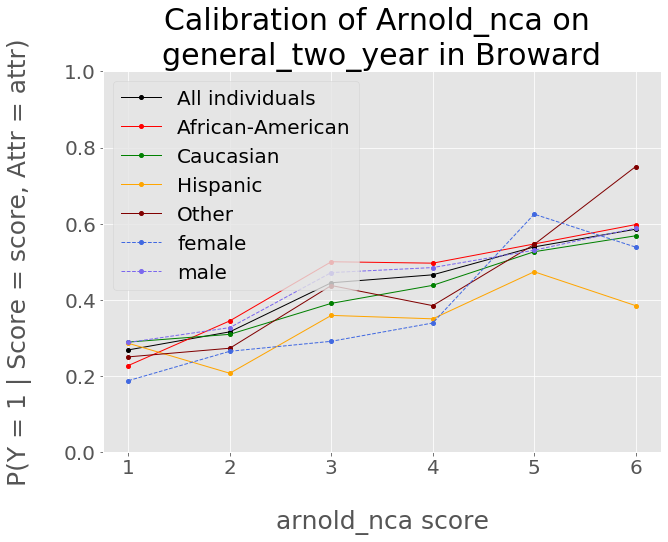

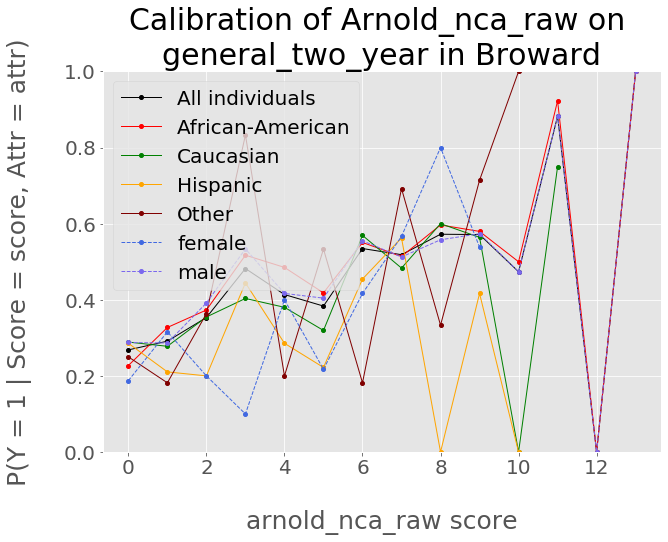

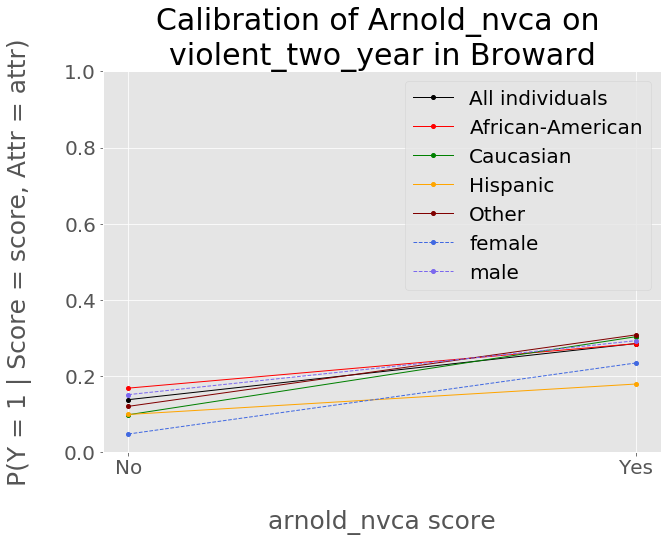

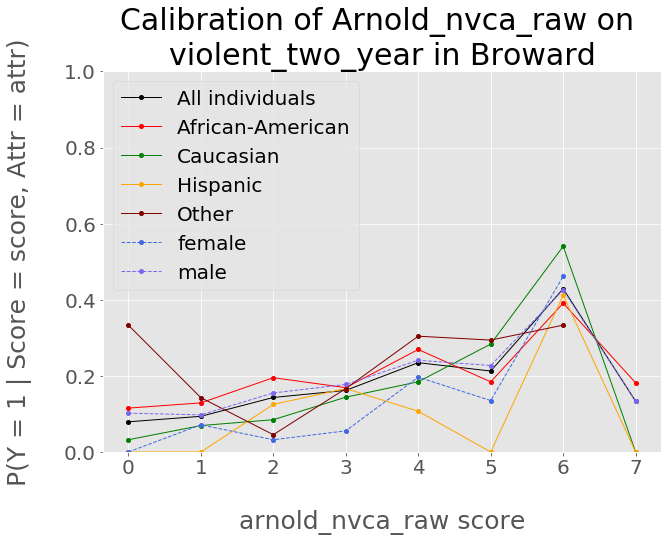

In [4]:
# calibration of PSA
scores_problem_dict = {'arnold_nca': ['general_two_year',
                                      'broward/logs/fairness_results/calibration_visualizations/arnold_nca_calib.pdf'],
                       'arnold_nca_raw': ['general_two_year', 
                                          'broward/logs/fairness_results/calibration_visualizations/arnold_nca_raw_calib.pdf'],
                       'arnold_nvca': ['violent_two_year', 
                                       'broward/logs/fairness_results/calibration_visualizations/arnold_ncva_calib.pdf'], 
                       'arnold_nvca_raw': ['violent_two_year', 
                                           'broward/logs/fairness_results/calibration_visualizations/arnold_ncva_raw_calib.pdf']
                      }

for score_name, (problem_name, save_path) in scores_problem_dict.items():
    calib, calib_grps = compute_calibration_discrete_score(long_df=broward_long, 
                                                            problem_name=problem_name, 
                                                            score_name=score_name)

    plot_calibration_for_score_on_problem(calib=calib,
                                          calib_grps=calib_grps,
                                           problem_name=problem_name,
                                           score_name=score_name,
                                           region="Broward",
                                           save_path=save_path)

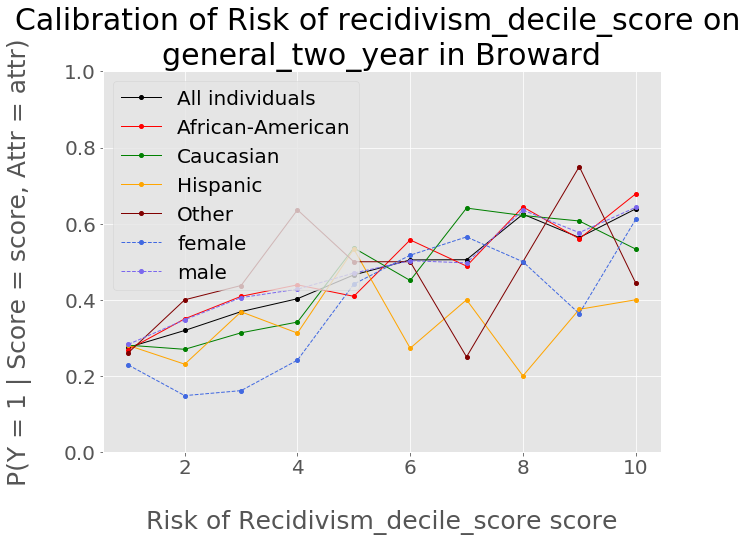

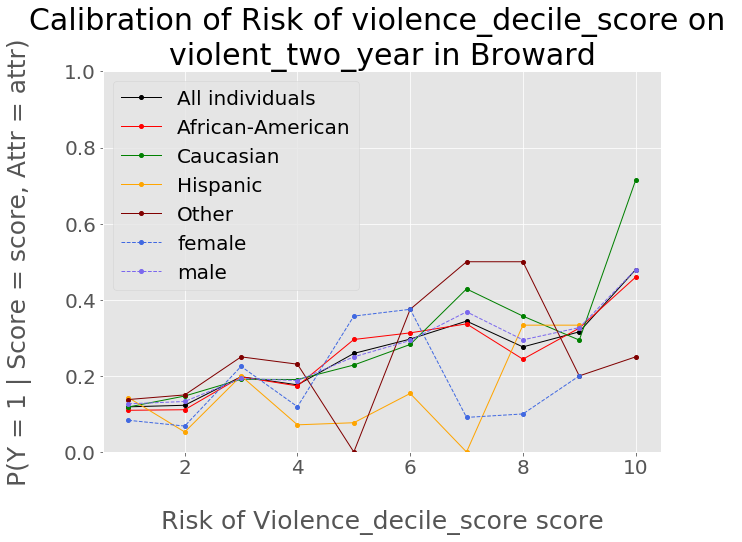

In [6]:
# calibration of COMPAS
scores_problem_dict = {'Risk of Recidivism_decile_score': ['general_two_year',
                                                           'broward/logs/fairness_results/calibration_visualizations/compas_recid_calib.pdf'],
                       'Risk of Violence_decile_score': ['violent_two_year',
                                                        'broward/logs/fairness_results/calibration_visualizations/compas_violence_calib.pdf']}

for score_name, (problem_name, save_path) in scores_problem_dict.items():
    
    calib, calib_grps = compute_calibration_discrete_score(long_df=broward_long, 
                                                            problem_name=problem_name, 
                                                            score_name=score_name)


    plot_calibration_for_score_on_problem(calib=calib, 
                                          calib_grps=calib_grps,
                                           problem_name=problem_name,
                                           score_name=score_name,
                                           region="Broward",
                                           save_path=save_path)

## Calibration of EBM and RiskSLIM

In [7]:
# read in calibration data for all problems 
calibration_data = {}
for time_period in [
                    "six_month", 
                    "two_year"
]:
    
    for problem in ['drug', 'felony', 'general', 'misdemeanor', 'property', 'violent']:
        problem_path = "broward/calibration_matrix/" + time_period + "/" + problem
        dircontents = os.listdir()
        onlyfiles = [f for f in os.listdir(problem_path) if os.path.isfile(os.path.join(problem_path, f))]
        
        for filename in onlyfiles:
            model_name = filename.split("_")[0]
            if model_name in ['ebm', 'riskslim', 'stumps']:
                calibration_data["-".join((problem, time_period, model_name))] = pd.read_csv(problem_path + "/" + filename)

calibration_data.keys()


dict_keys(['drug-six_month-ebm', 'drug-six_month-riskslim', 'drug-six_month-stumps', 'felony-six_month-ebm', 'felony-six_month-riskslim', 'felony-six_month-stumps', 'general-six_month-ebm', 'general-six_month-riskslim', 'general-six_month-stumps', 'misdemeanor-six_month-ebm', 'misdemeanor-six_month-riskslim', 'misdemeanor-six_month-stumps', 'property-six_month-ebm', 'property-six_month-riskslim', 'property-six_month-stumps', 'violent-six_month-ebm', 'violent-six_month-riskslim', 'violent-six_month-stumps', 'drug-two_year-ebm', 'drug-two_year-riskslim', 'drug-two_year-stumps', 'felony-two_year-ebm', 'felony-two_year-riskslim', 'felony-two_year-stumps', 'general-two_year-ebm', 'general-two_year-riskslim', 'general-two_year-stumps', 'misdemeanor-two_year-ebm', 'misdemeanor-two_year-riskslim', 'misdemeanor-two_year-stumps', 'property-two_year-ebm', 'property-two_year-riskslim', 'property-two_year-stumps', 'violent-two_year-ebm', 'violent-two_year-riskslim', 'violent-two_year-stumps'])

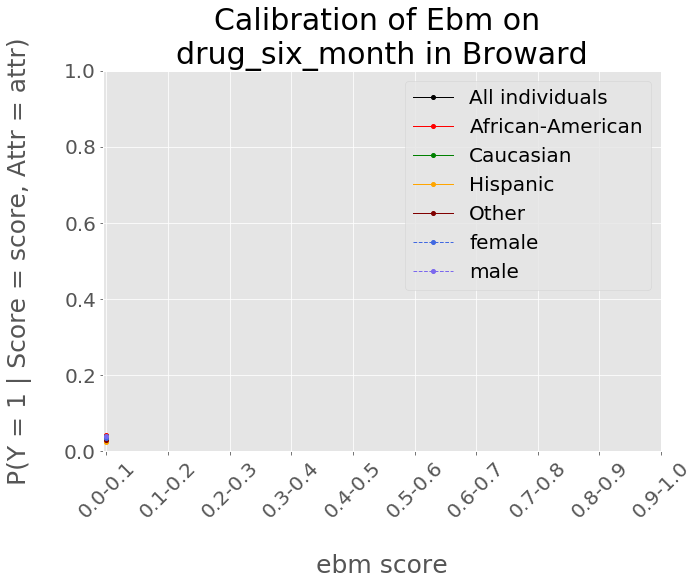

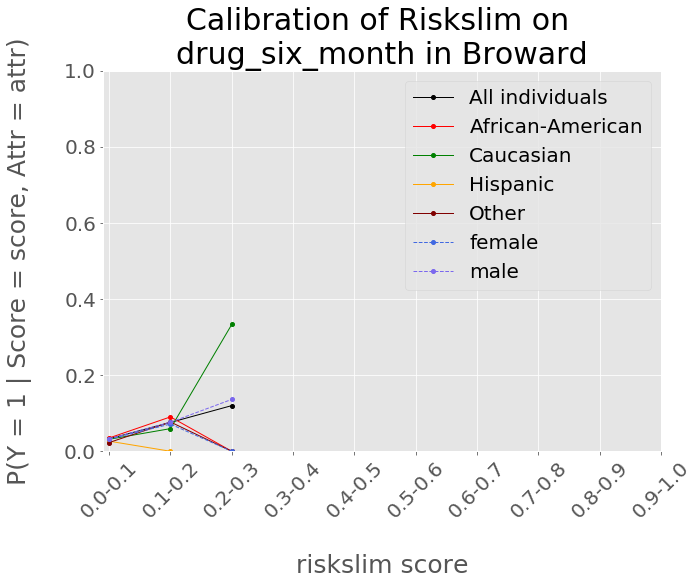

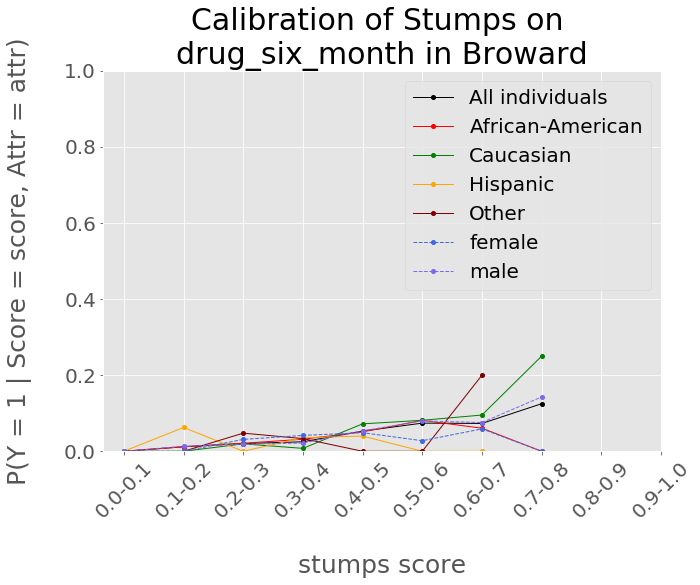

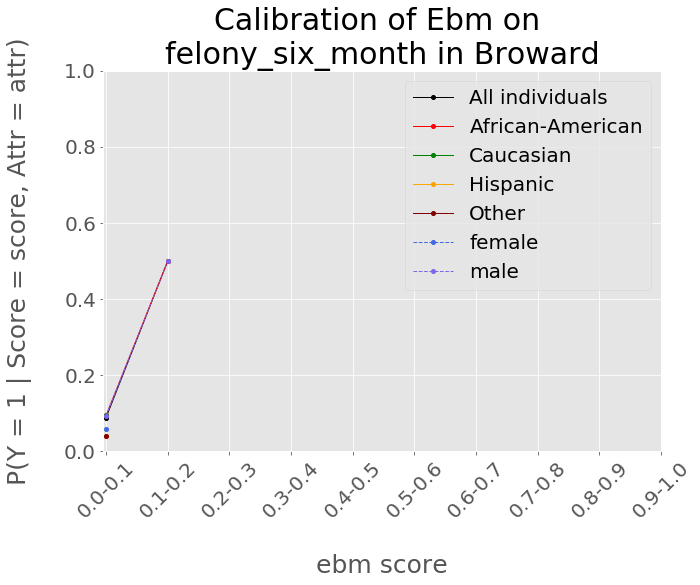

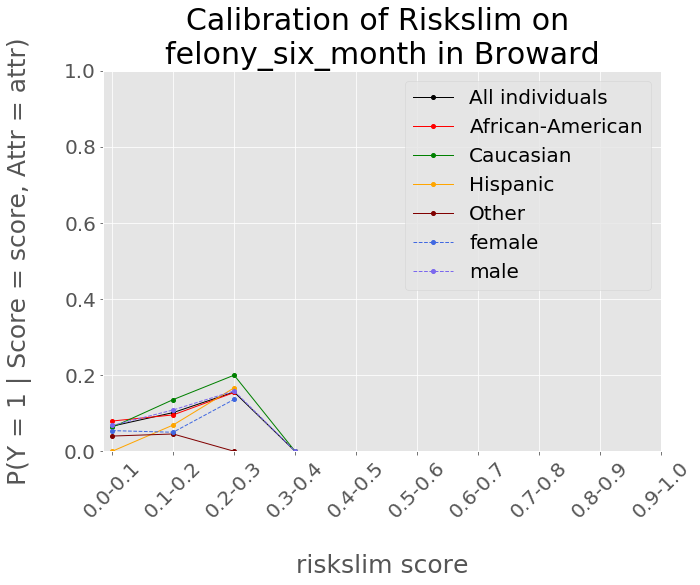

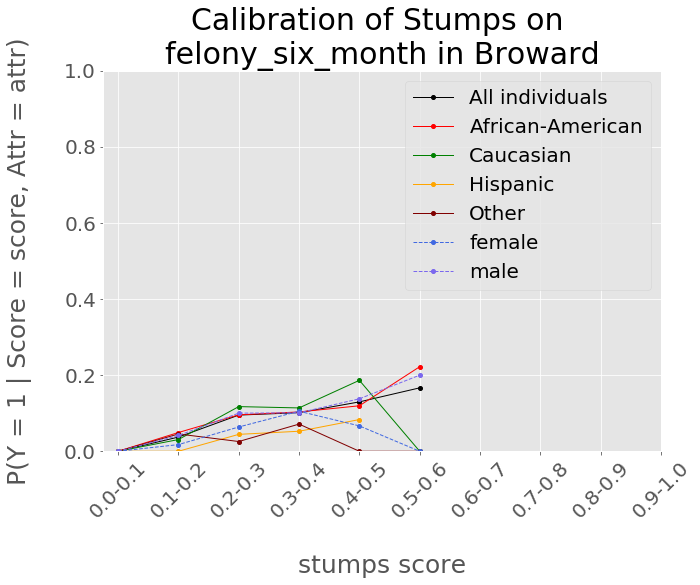

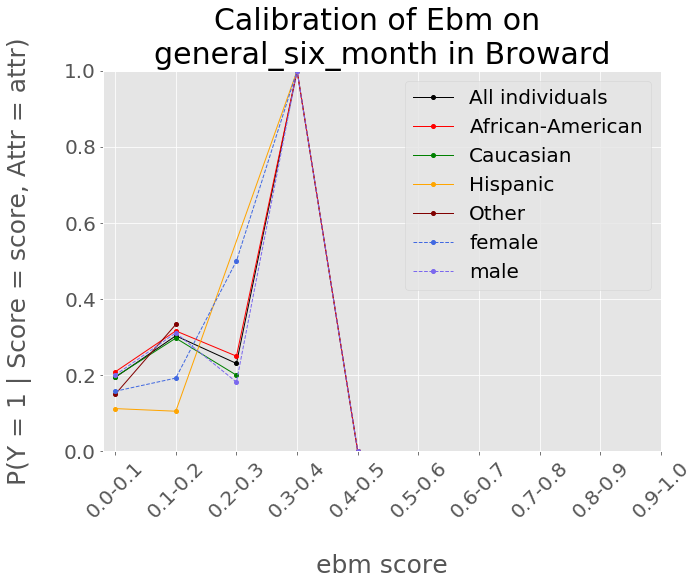

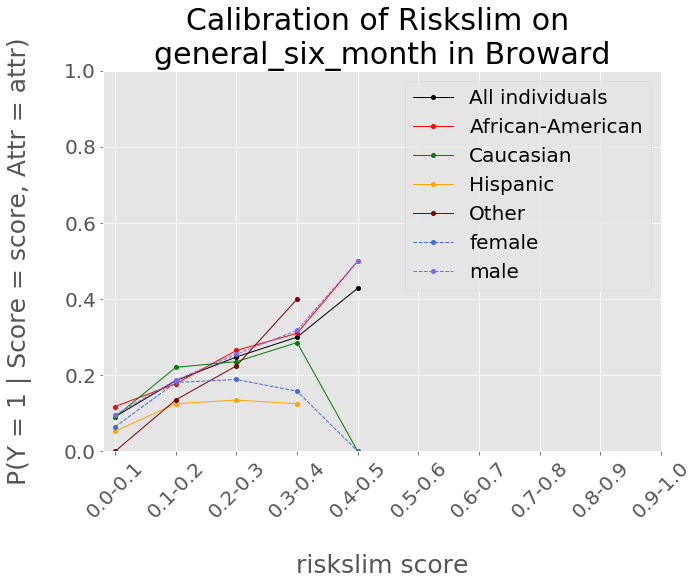

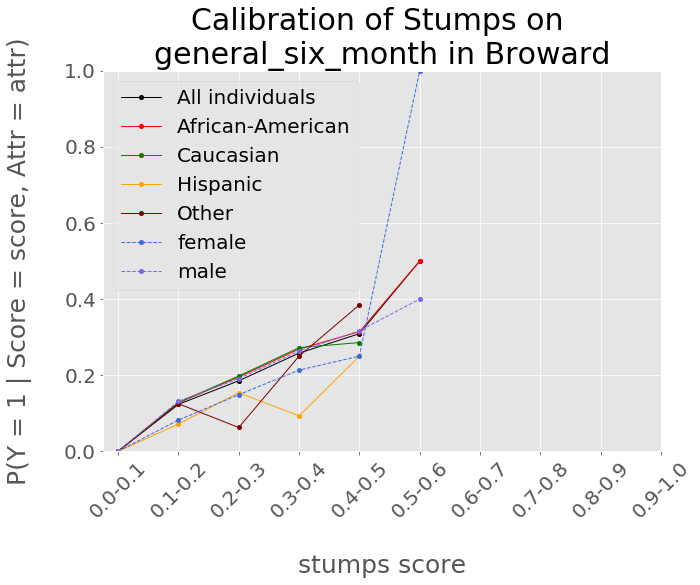

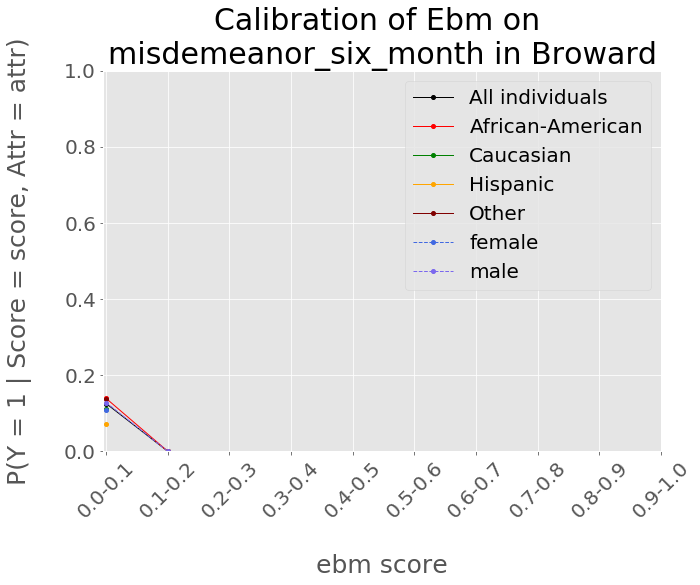

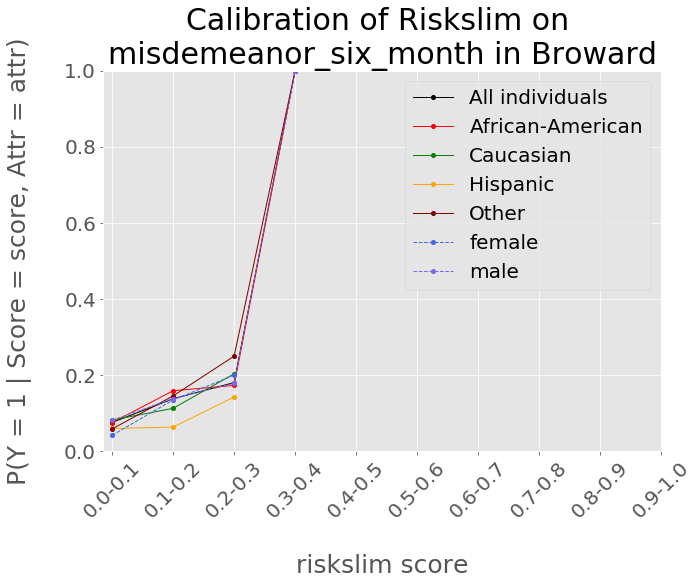

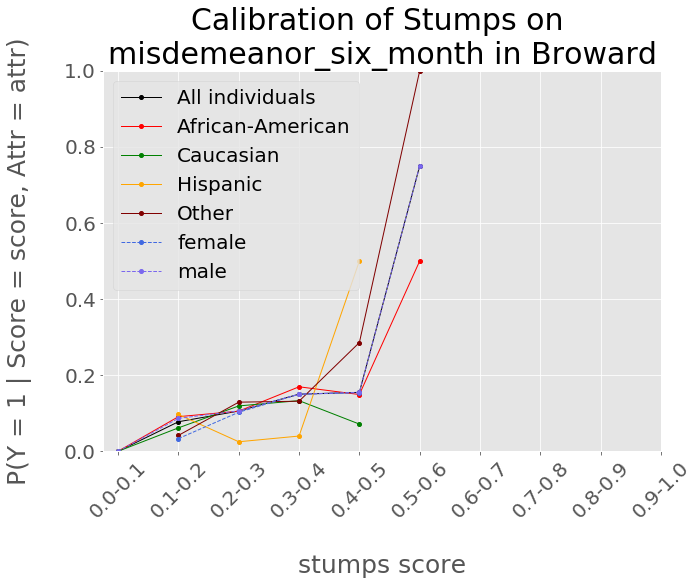

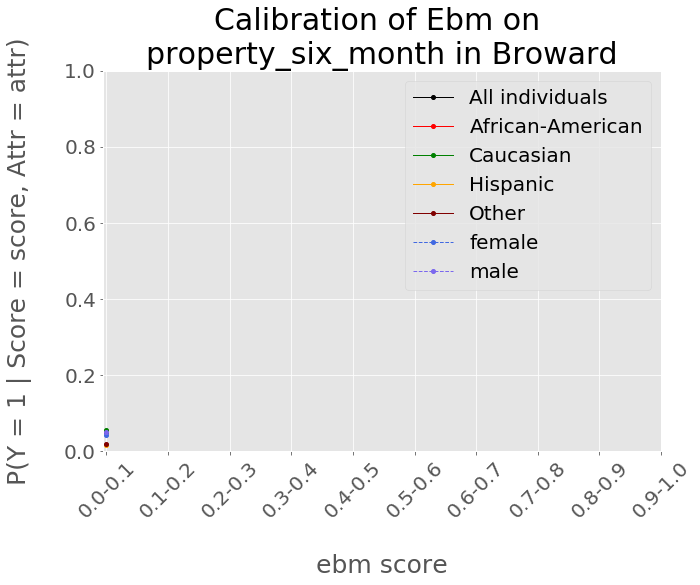

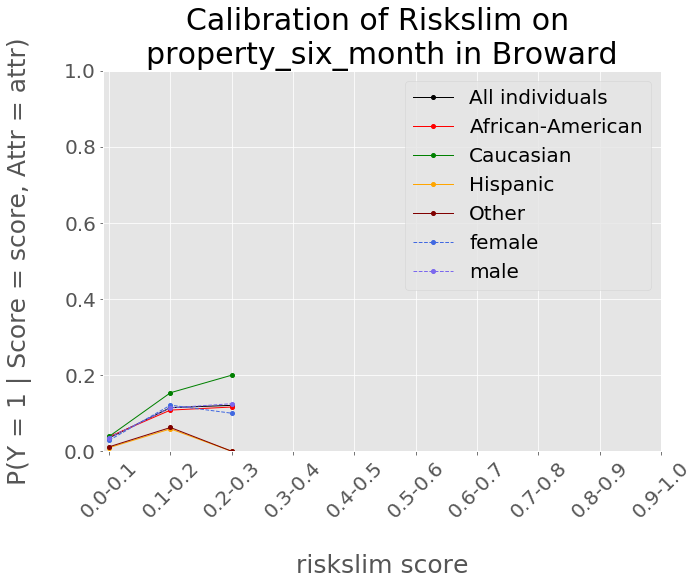

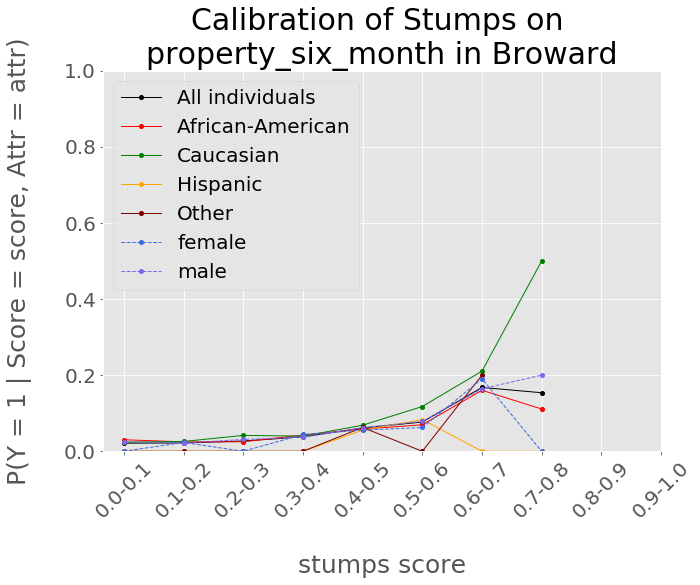

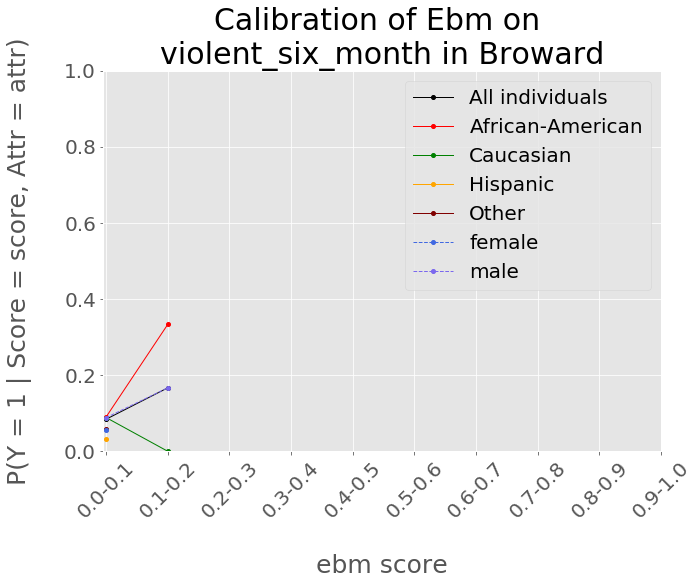

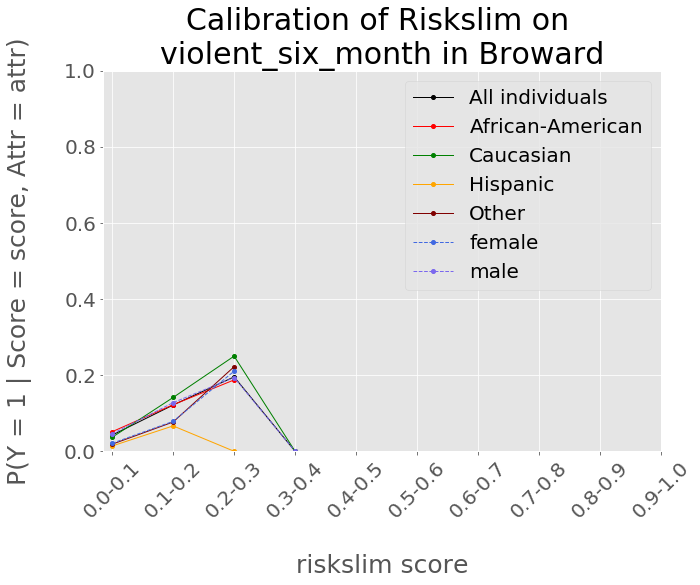

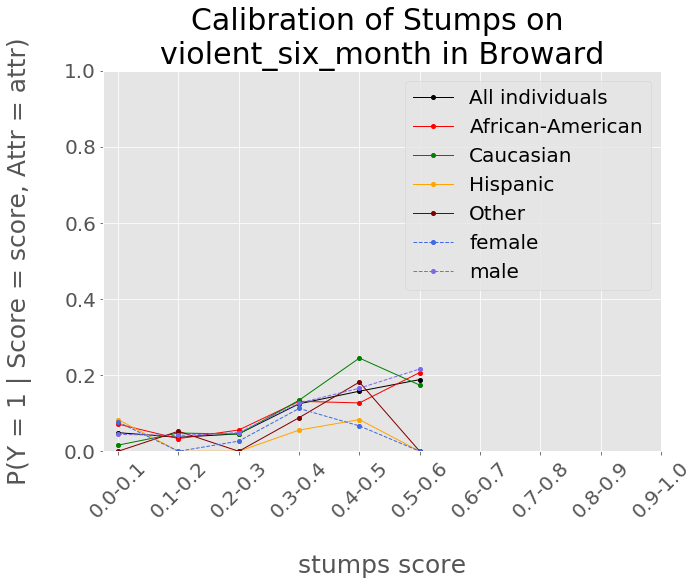

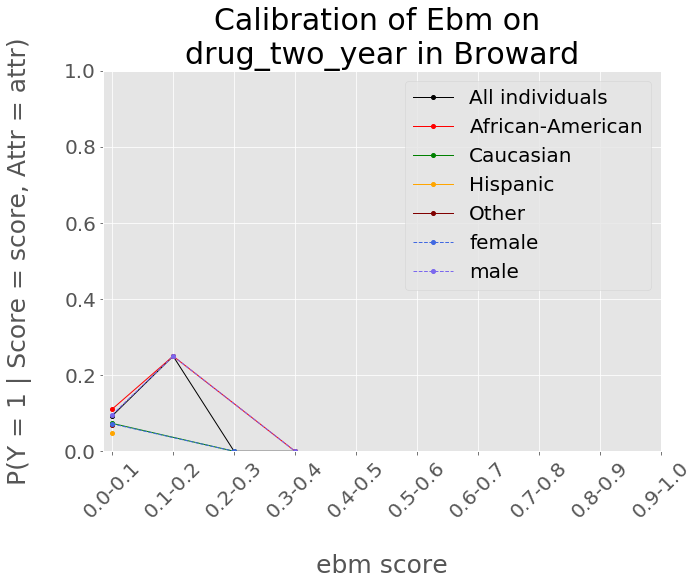

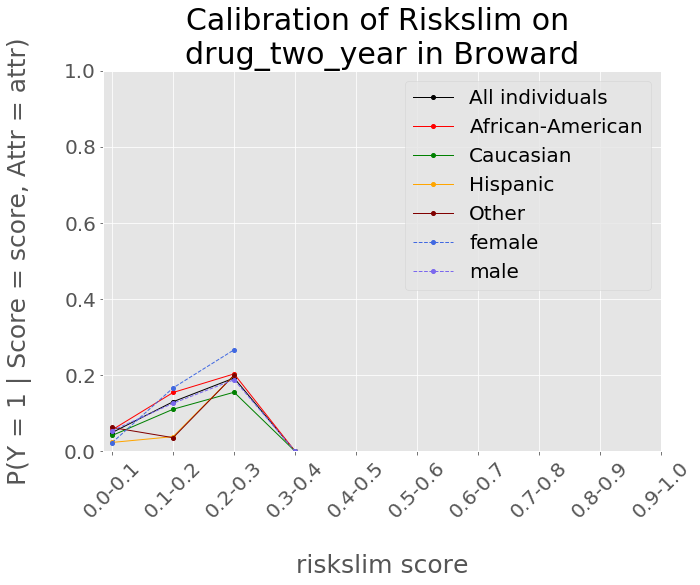

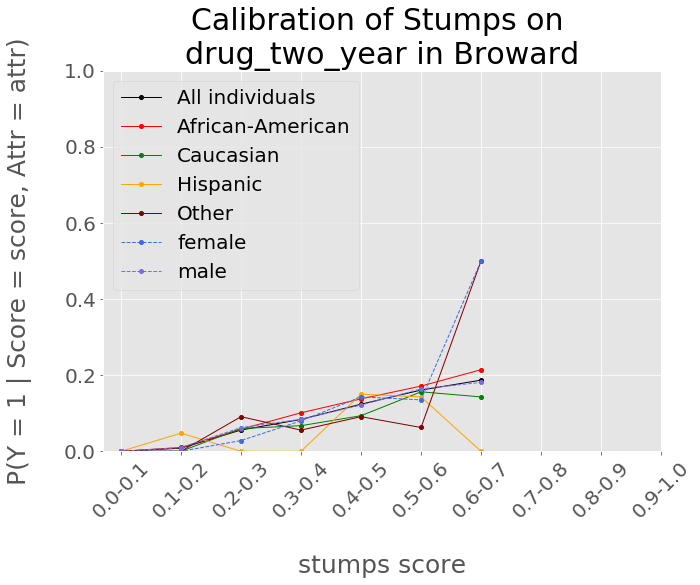

In [ ]:
for name, calib_summary in calibration_data.items():
    recid_type, time_period, score_name = name.split("-")
    problem_name = "_".join([recid_type, time_period])

    calib, calib_grps = parse_calibration_matrix(calibration_matrix=calib_summary, 
                                                 problem_name=problem_name, 
                                                 score_name=score_name)
    
    plot_calibration_for_score_on_problem(calib=calib,
                                          calib_grps=calib_grps,
                                          problem_name=problem_name,
                                          score_name=score_name,
                                          region="Broward",
                                          xtick_labels=['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5','0.5-0.6', 
                                                        '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0'],
                                          rotate_xticks=True,
                                          save_path="broward/logs/fairness_results/calibration_visualizations/" 
                                                      + score_name + "/" 
                                                      + score_name + "_" + problem_name + ".pdf")